# **PART 0: RLIBS SETUP**

Load R magic extension & Mount Google Drive

In [1]:
%load_ext rpy2.ipython
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Setup Google Drive directory to R package library

In [2]:
%%R
.libPaths("/content/drive/MyDrive/R_ggColab_Thien/Rlibs")

Load required libraries

In [3]:
%%R
library(DMRcate)
library(ExperimentHub)
library(data.table)
library(minfi)
library(GenomicRanges)
library(qs)
library(knitr)
library(IlluminaHumanMethylationEPICanno.ilm10b4.hg19)

Setting options('download.file.method.GEOquery'='auto')
Setting options('GEOquery.inmemory.gpl'=FALSE)

Loading required package: BiocGenerics

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min

Loading required package: AnnotationHub
Loading required package: BiocFileCache
Loading required package: dbplyr
data.table 1.17.0 using 1 threads (see ?getDTthreads).  Latest news: r-datatable.com
Loading required package: GenomicRanges
Loading required package: stats4
Loadin

Global setup

In [4]:
%%R
set.seed(123)
Sys.setenv("VROOM_CONNECTION_SIZE" = 131072 * 1000)  # Increase buffer size
options(timeout = 3600)  # Increase timeout for slow GEO servers

Directory setup

In [5]:
%%R
gse_acc <- "GSE169622"
dir_op <- file.path("/content/drive/MyDrive/R_ggColab_Thien", gse_acc)
setwd(dir_op)

dir_op.raw <- file.path(dir_op, "01.Raw")
dir_op.qc <- file.path(dir_op, "02.QC")
dir_op.methProbes <- file.path(dir_op, "03.methProbes")

dir_op.dmrcate <- file.path(dir_op, "04.DMRcate_results")
if (!dir.exists(dir_op.dmrcate)) {dir.create(dir_op.dmrcate)}


# **PART 1: DATA PREPARATION**

Load metadata

In [6]:
%%R
metaDT_Sub <- fread(file.path(dir_op.raw, "Metadata_Sub.csv"), header = TRUE, data.table = FALSE)

Load methylation matrix

In [7]:
%%R
bVals <- fread(file.path(dir_op.methProbes, "bigTable.hg19.tsv"), header = TRUE, data.table = FALSE, sep = "\t")
rownames(bVals) <- bVals$probeID

|--------------------------------------------------|
|==================================================|


# **PART 2: DMPs CALLING**

## 2.1. CpG sites annotating with `cpg.annotate()`

Subset only chromosome 2, 6 and X for example. You can run this step with full data if possible

In [ ]:
%%R
print(kable(t(sort(table(bVals$seqnames)))))



| chrY| chr21| chr18| chr22|  chrX| chr13| chr20|  chr9| chr15| chr14|  chr4| chr16| chr19|  chr8| chr10| chr17| chr12|  chr5|  chr7| chr11|  chr3|  chr6|  chr2|  chr1|
|----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
|   91|  9409| 13871| 16511| 17458| 19084| 21408| 24085| 25970| 27135| 33419| 34253| 35028| 35202| 38480| 40697| 41035| 41052| 42361| 45246| 45295| 49199| 59412| 75127|


In [ ]:
%%R
bVals_subset <- as.matrix(bVals[bVals$seqnames %in% c("chr2", "chr6", "chrX"), -c(1:6)])

Create design matrix

In [9]:
%%R
type <- factor(metaDT_Sub$diseasestate)
design <- model.matrix(~type)
print(design)

  (Intercept) typenormal
1           1          1
2           1          1
3           1          1
4           1          0
5           1          0
6           1          0
7           1          0
8           1          0
9           1          0
attr(,"assign")
[1] 0 1
attr(,"contrasts")
attr(,"contrasts")$type
[1] "contr.treatment"



Annotate CpG sites from subset data

In [ ]:
%%R
myannotation <- cpg.annotate(object = bVals_subset,
                             design = design,
                             datatype = "array",
                             arraytype = "EPICv1",
                             analysis.type = "differential",
                             what = "Beta",
                             coef = 2,
                             epicv2Remap = FALSE)
print(myannotation)

CpGannotated object describing 126069 CpG sites, with independent
CpG threshold indexed at fdr=0.05 and 17464 significant CpG sites.


Your contrast returned 17464 individually significant probes. We recommend the default setting of pcutoff in dmrcate().
In addition: Warning messages:
1: Zero sample variances detected, have been offset away from zero 
2: Zero sample variances detected, have been offset away from zero 


In [ ]:
%%R
print(myannotation@ranges)

GRanges object with 126069 ranges and 5 metadata columns:
                 seqnames    ranges strand |       stat        diff   rawpval
                    <Rle> <IRanges>  <Rle> |  <numeric>   <numeric> <numeric>
      chr2:42968     chr2     42968      * |   1.257840   0.0983333 0.2344339
      chr2:42998     chr2     42998      * |   2.934264   0.1700000 0.0135542
      chr2:43812     chr2     43812      * |   1.909840   0.1300000 0.0824981
      chr2:43953     chr2     43953      * |   1.172591   0.0916667 0.2656693
      chr2:45264     chr2     45264      * |   0.711561   0.0316667 0.4915161
             ...      ...       ...    ... .        ...         ...       ...
  chrX:154843390     chrX 154843390      * | -0.9877208 -0.03166667  0.344467
  chrX:154845915     chrX 154845915      * |  1.2204771  0.01666667  0.247741
  chrX:154891969     chrX 154891969      * |  0.7216697  0.03500000  0.485519
  chrX:154899767     chrX 154899767      * | -0.2886506 -0.00500000  0.778203
  chrX

> `diff` is the precision-weighted methylation difference, giving more weight to CpG sites or samples with higher read coverage and lower variance, for a more reliable estimate.

In [ ]:
%%R
myannotation@ranges@ranges@NAMES <- rownames(bVals_subset)
print(myannotation@ranges)
# qsave(myannotation, file = file.path(dir_op.dmrcate, "cpg.annotate.RDS"))

GRanges object with 126069 ranges and 5 metadata columns:
             seqnames    ranges strand |       stat        diff   rawpval
                <Rle> <IRanges>  <Rle> |  <numeric>   <numeric> <numeric>
  cg00001594     chr2     42968      * |   1.257840   0.0983333 0.2344339
  cg00001747     chr2     42998      * |   2.934264   0.1700000 0.0135542
  cg00001791     chr2     43812      * |   1.909840   0.1300000 0.0824981
  cg00001814     chr2     43953      * |   1.172591   0.0916667 0.2656693
  cg00002145     chr2     45264      * |   0.711561   0.0316667 0.4915161
         ...      ...       ...    ... .        ...         ...       ...
  cg27653023     chrX 154843390      * | -0.9877208 -0.03166667  0.344467
  cg27654334     chrX 154845915      * |  1.2204771  0.01666667  0.247741
  cg27656519     chrX 154891969      * |  0.7216697  0.03500000  0.485519
  cg27659725     chrX 154899767      * | -0.2886506 -0.00500000  0.778203
  cg27665489     chrX 154915967      * |  0.0942907  0

## 2.2. Getting DMPs ranking

In [ ]:
%%R
cpSites <- as.data.frame(myannotation@ranges)
cpSites$probeID <- rownames(cpSites)
kable(head(cpSites))



|           |seqnames | start|   end| width|strand |      stat|      diff|   rawpval|   ind.fdr|is.sig |probeID    |
|:----------|:--------|-----:|-----:|-----:|:------|---------:|---------:|---------:|---------:|:------|:----------|
|cg00001594 |chr2     | 42968| 42968|     1|*      | 1.2578404| 0.0983333| 0.2344339| 0.4171879|FALSE  |cg00001594 |
|cg00001747 |chr2     | 42998| 42998|     1|*      | 2.9342643| 0.1700000| 0.0135542| 0.0730710|FALSE  |cg00001747 |
|cg00001791 |chr2     | 43812| 43812|     1|*      | 1.9098396| 0.1300000| 0.0824981| 0.2162358|FALSE  |cg00001791 |
|cg00001814 |chr2     | 43953| 43953|     1|*      | 1.1725909| 0.0916667| 0.2656693| 0.4509825|FALSE  |cg00001814 |
|cg00002145 |chr2     | 45264| 45264|     1|*      | 0.7115608| 0.0316667| 0.4915161| 0.6625920|FALSE  |cg00002145 |
|cg00002350 |chr2     | 45511| 45511|     1|*      | 1.7230615| 0.0683333| 0.1127661| 0.2632031|FALSE  |cg00002350 |


Compute mean differences between two groups

In [ ]:
%%R
designTSV <- metaDT_Sub[, c("title", "diseasestate")]
colnames(designTSV) <- c("title", "groups")
Beta.g1 <- apply(bVals_subset[, designTSV[designTSV$groups == levels(type)[1], "title"]], 1, mean)
Beta.g2 <- apply(bVals_subset[, designTSV[designTSV$groups != levels(type)[1], "title"]], 1, mean)
delta <- data.frame(delta = Beta.g1 - Beta.g2)
kable(head(delta))



|           |      delta|
|:----------|----------:|
|cg00001594 | -0.0250000|
|cg00001747 |  0.4066667|
|cg00001791 |  0.0216667|
|cg00001814 | -0.1266667|
|cg00002145 |  0.0383333|
|cg00002350 |  0.0200000|


> `delta` is the raw difference in mean methylation between groups, useful for a quick overview but less reliable when data varies in coverage or variance.

Merge methylation difference into DMPs

In [ ]:
%%R
cpSites <- base::merge(cpSites, delta, by.x = "probeID", by.y = "row.names")
# fwrite(cpSites, file.path(dir_op.dmrcate, "DMP.hg19.tsv"), sep = "\t", col.names = TRUE, quote = FALSE, row.names = FALSE)

# **PART 3: DMR CALLING**

## 3.1. DMRs calling with `DMRcate()`

**What does dmrcate() do?**
1. Smoothing across nearby CpGs (kernel smoothing):
  * Applies a Gaussian kernel to smooth differential methylation statistics across the genome.
  * Each CpG’s signal is averaged with nearby CpGs, weighted by genomic distance:
    * Closer CpGs contribute more.
    * Farther CpGs (e.g., >1000 bp) contribute less or nothing.
  * Controlled by the `lambda` parameter (default `lambda` = 1000), which defines the maximum distance between CpGs considered neighbors.

2. Detecting significant regions (DMRs):
  * After smoothing, the method combines signals across CpGs (e.g., using Stouffer’s Z-score) to quantify the regional strength of differential methylation.
  * The `C` parameter sets the minimum smoothed test statistic threshold for reporting a DMR.
    * Default: `C = 2` ≈ p-value of 0.05 (under normal distribution).


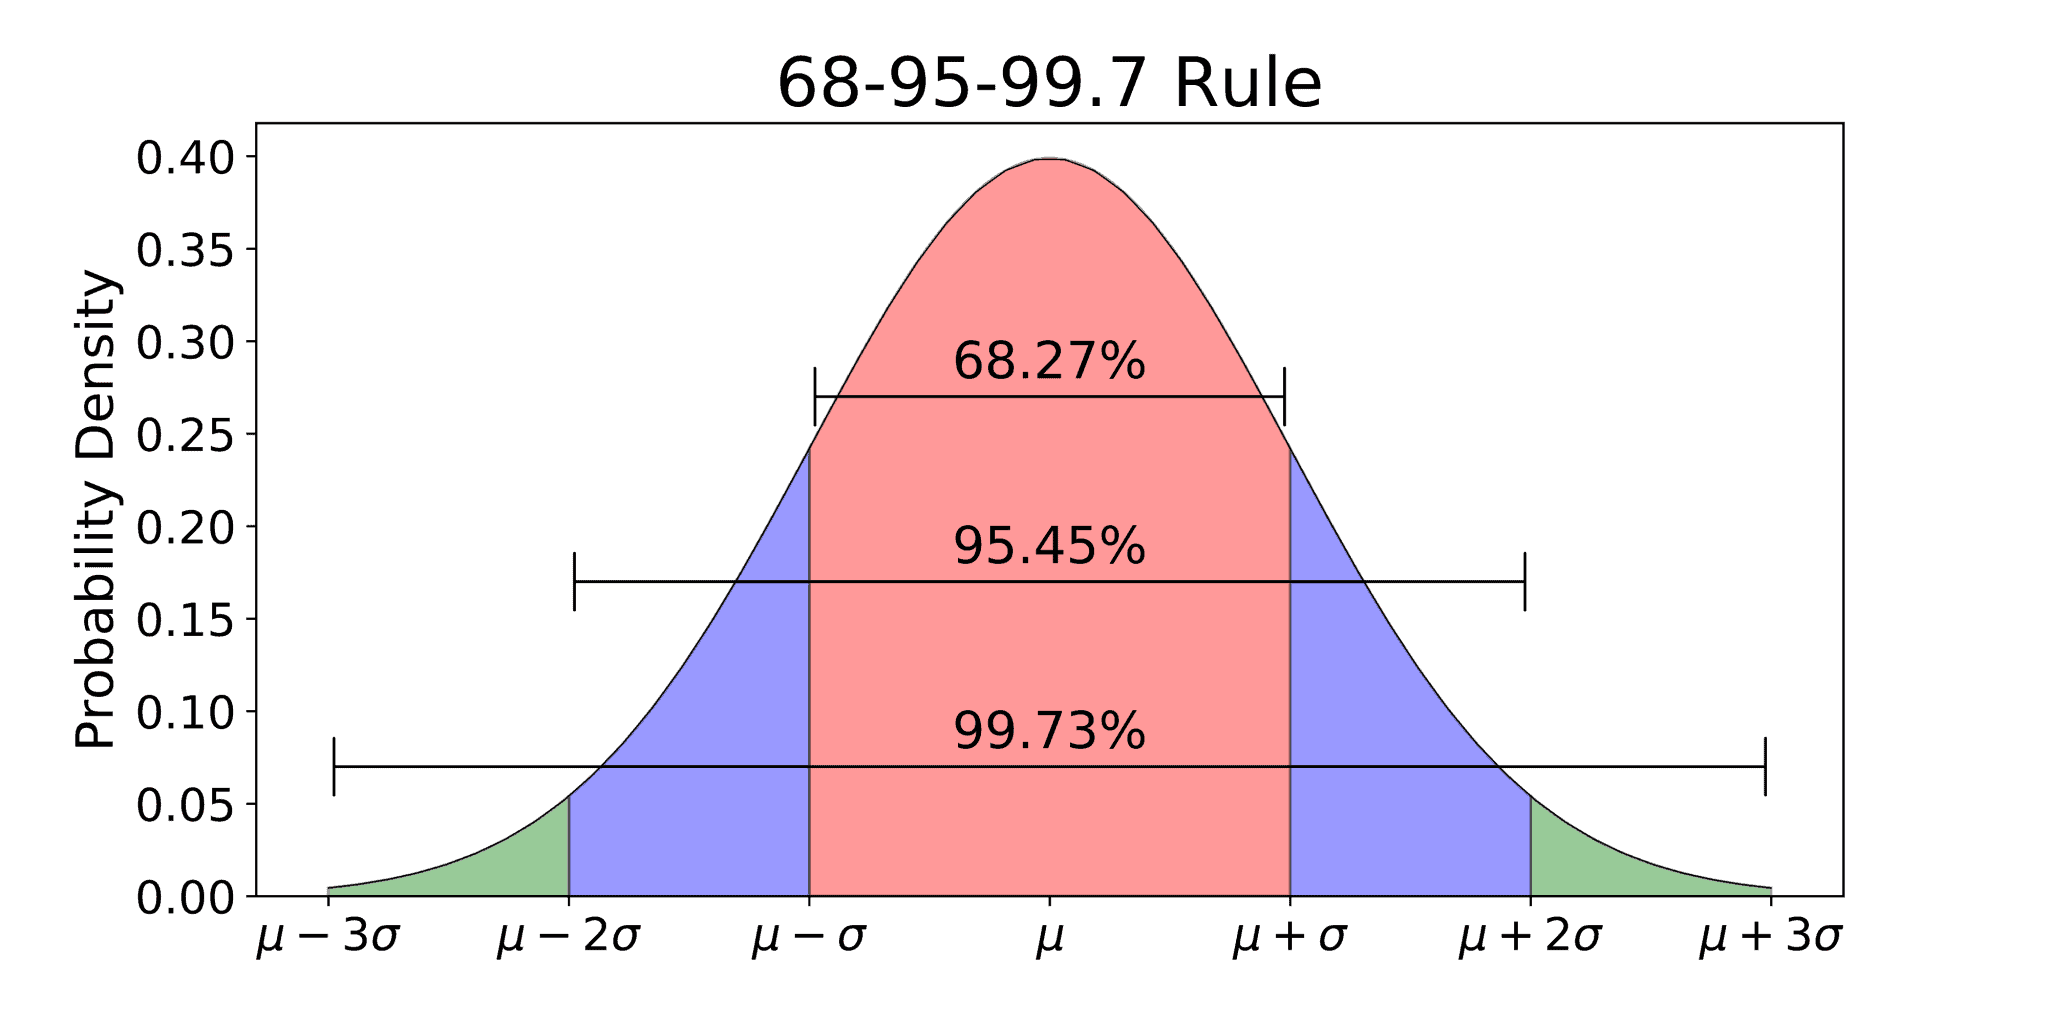

In [ ]:
%%R
dmrcoutput <- dmrcate(myannotation, lambda = 1000, C = 2)
print(dmrcoutput)
# qsave(dmrcoutput, file = file.path(dir_op.dmrcate, "DMR.RDS"))

DMResults object with 1866 DMRs.
Use extractRanges() to produce a GRanges object of these.


Fitting chr2...
Fitting chr6...
Fitting chrX...
Demarcating regions...
Done!


## 3.2. Getting DMRs ranking

In [ ]:
%%R
results.ranges <- extractRanges(dmrcoutput, genome = "hg19")
print(results.ranges)

GRanges object with 1866 ranges and 8 metadata columns:
         seqnames              ranges strand |   no.cpgs min_smoothed_fdr
            <Rle>           <IRanges>  <Rle> | <integer>        <numeric>
     [1]     chr6 166579057-166583523      * |        24      0.00000e+00
     [2]     chr2 107501733-107504523      * |        21     1.41421e-286
     [3]     chr6   28602513-28603779      * |        36     3.04122e-265
     [4]     chr2 155553986-155556321      * |        19     1.73675e-219
     [5]     chr6     7248862-7248983      * |         3     6.13891e-217
     ...      ...                 ...    ... .       ...              ...
  [1862]     chr2 131673894-131673963      * |         2      6.93068e-09
  [1863]     chr2   32502781-32502885      * |         3      7.03749e-09
  [1864]     chrX   55291317-55291412      * |         4      7.07747e-09
  [1865]     chr2 220381808-220381812      * |         2      7.30589e-09
  [1866]     chr6 151713355-151713358      * |         2

snapshotDate(): 2024-10-24
see ?DMRcatedata and browseVignettes('DMRcatedata') for documentation
loading from cache


In [ ]:
# %%R
# qsave(results.ranges, file = file.path(dir_op.dmrcate, "DMRrange.hg19.RDS"))